In [0]:
import pandas as pd
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("DemandForecasting").getOrCreate()
file_path = "dbfs:/FileStore/shared_uploads/podurikarthikeya69@gmail.com/Demm_data.csv"  # Update with your file path
df = spark.read.csv(file_path, header=True, inferSchema=True)
df.show(5)


+--------------+------+------+------+------------+------------+--------------+----------+----------------+----------------+------------------------+----+--------+-----+-----+-----------+---------------------+-------------------------+
|    HostItemID|  Cost|  List|OnHand|MonthsNoSale|LastSaleDate|PriorYearSales|OnOrderQty|BestReorderPoint|SafetyStockLevel|MonthsWithAtLeastOneSale|Year|   Month|Sales|Lag_1|HolidayFlag|InventoryDiff_Reorder|InventoryDiff_SafetyStock|
+--------------+------+------+------+------------+------------+--------------+----------+----------------+----------------+------------------------+----+--------+-----+-----+-----------+---------------------+-------------------------+
|PMP*14680*2541|381.96|873.72|   184|          17|  2021-04-17|           217|        62|              74|              39|                       8|2021| January|   39|  NaN|          0|                  110|                       70|
|PMP*14680*2541|381.96|873.72|   184|          17|  2021-04-

In [0]:
from pyspark.sql import functions as F
missing_values = df.select([F.sum(F.col(col).isNull().cast("int")).alias(col) for col in df.columns])
missing_values.show()

+----------+----+----+------+------------+------------+--------------+----------+----------------+----------------+------------------------+----+-----+-----+-----+-----------+---------------------+-------------------------+
|HostItemID|Cost|List|OnHand|MonthsNoSale|LastSaleDate|PriorYearSales|OnOrderQty|BestReorderPoint|SafetyStockLevel|MonthsWithAtLeastOneSale|Year|Month|Sales|Lag_1|HolidayFlag|InventoryDiff_Reorder|InventoryDiff_SafetyStock|
+----------+----+----+------+------------+------------+--------------+----------+----------------+----------------+------------------------+----+-----+-----+-----+-----------+---------------------+-------------------------+
|         0|   0|   0|     0|           0|           0|             0|         0|               0|               0|                       0|   0|    0|    0|    0|          0|                    0|                        0|
+----------+----+----+------+------------+------------+--------------+----------+----------------+------

In [0]:
df.printSchema()

root
 |-- HostItemID: string (nullable = true)
 |-- Cost: double (nullable = true)
 |-- List: double (nullable = true)
 |-- OnHand: integer (nullable = true)
 |-- MonthsNoSale: integer (nullable = true)
 |-- LastSaleDate: date (nullable = true)
 |-- PriorYearSales: integer (nullable = true)
 |-- OnOrderQty: integer (nullable = true)
 |-- BestReorderPoint: integer (nullable = true)
 |-- SafetyStockLevel: integer (nullable = true)
 |-- MonthsWithAtLeastOneSale: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- Sales: integer (nullable = true)
 |-- Lag_1: double (nullable = true)
 |-- HolidayFlag: integer (nullable = true)
 |-- InventoryDiff_Reorder: integer (nullable = true)
 |-- InventoryDiff_SafetyStock: integer (nullable = true)



In [0]:
from pyspark.sql.functions import to_date

df = df.withColumn("LastSaleDate", to_date(df["LastSaleDate"], "yyyy-MM-dd"))

In [0]:
df.printSchema()

root
 |-- HostItemID: string (nullable = true)
 |-- Cost: double (nullable = true)
 |-- List: double (nullable = true)
 |-- OnHand: integer (nullable = true)
 |-- MonthsNoSale: integer (nullable = true)
 |-- LastSaleDate: date (nullable = true)
 |-- PriorYearSales: integer (nullable = true)
 |-- OnOrderQty: integer (nullable = true)
 |-- BestReorderPoint: integer (nullable = true)
 |-- SafetyStockLevel: integer (nullable = true)
 |-- MonthsWithAtLeastOneSale: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- Sales: integer (nullable = true)
 |-- Lag_1: double (nullable = true)
 |-- HolidayFlag: integer (nullable = true)
 |-- InventoryDiff_Reorder: integer (nullable = true)
 |-- InventoryDiff_SafetyStock: integer (nullable = true)



In [0]:
from pyspark.sql.window import Window
window_spec = Window.partitionBy("HostItemID").orderBy("LastSaleDate")
df = df.withColumn("Lag_1", F.lag("Sales", 1).over(window_spec))

In [0]:
df = df.withColumn("Month_Indicator", F.lit(None))
month_mapping = {
    "January": 1, "February": 2, "March": 3, "April": 4,
    "May": 5, "June": 6, "July": 7, "August": 8,
    "September": 9, "October": 10, "November": 11, "December": 12
}

for month_name, month_num in month_mapping.items():
    df = df.withColumn("Month_Indicator", 
                       F.when(F.col("Month") == month_name, month_num).otherwise(F.col("Month_Indicator")))

In [0]:
df = df.drop("MonthsNoSale", "MonthsWithAtLeastOneSale")  

In [0]:
df.show(5)

+--------------+------+------+------+------------+--------------+----------+----------------+----------------+----+--------+-----+-----+-----------+---------------------+-------------------------+---------------+
|    HostItemID|  Cost|  List|OnHand|LastSaleDate|PriorYearSales|OnOrderQty|BestReorderPoint|SafetyStockLevel|Year|   Month|Sales|Lag_1|HolidayFlag|InventoryDiff_Reorder|InventoryDiff_SafetyStock|Month_Indicator|
+--------------+------+------+------+------------+--------------+----------+----------------+----------------+----+--------+-----+-----+-----------+---------------------+-------------------------+---------------+
|PMP*14680*2541|381.96|873.72|   184|  2021-04-17|           217|        62|              74|              39|2021| January|   39| null|          0|                  110|                       70|              1|
|PMP*14680*2541|381.96|873.72|   184|  2021-04-17|           217|        62|              74|              39|2021|February|   39|   39|          0|

In [0]:
df = df.orderBy("HostItemID", "LastSaleDate")
df_pandas = df.toPandas()
df_pandas.set_index("LastSaleDate", inplace=True)

In [0]:
from statsmodels.tsa.arima.model import ARIMA
host_item_id = "PMP*14680*2541" 
series = df_pandas[df_pandas['HostItemID'] == host_item_id]['Sales']
model = ARIMA(series, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   28
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -109.960
Date:                Mon, 07 Oct 2024   AIC                            225.920
Time:                        07:25:11   BIC                            229.807
Sample:                             0   HQIC                           227.076
                                 - 28                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3632      0.807     -0.450      0.653      -1.946       1.219
ma.L1         -0.0020      0.822     -0.002      0.998      -1.612       1.608
sigma2       200.7407     70.106      2.863      0.0

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [0]:
forecast = model_fit.forecast(steps=12)
print(f"Forecasted Sales for the next 12 months:\n{forecast}")

Forecasted Sales for the next 12 months:
28    23.462060
29    22.931084
30    23.123918
31    23.053887
32    23.079320
33    23.070083
34    23.073438
35    23.072219
36    23.072662
37    23.072501
38    23.072560
39    23.072538
Name: predicted_mean, dtype: float64


/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [0]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
actual_sales = series[-12:].values
predicted_sales = forecast 
mae = mean_absolute_error(actual_sales, predicted_sales)
mse = mean_squared_error(actual_sales, predicted_sales)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_sales - predicted_sales) / actual_sales)) * 100
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

Mean Absolute Error (MAE): 9.95
Mean Absolute Percentage Error (MAPE): inf%
Root Mean Squared Error (RMSE): 13.44


In [0]:
smape = 100/len(actual_sales) * np.sum(2 * np.abs(predicted_sales - actual_sales) / (np.abs(actual_sales) + np.abs(predicted_sales)))

print(f'Symmetric Mean Absolute Percentage Error (SMAPE): {smape:.2f}%')

Symmetric Mean Absolute Percentage Error (SMAPE): 45.68%


2024/10/07 07:25:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/07 07:25:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run adaptable-hog-130 at: https://community.cloud.databricks.com/ml/experiments/781064694264649/runs/360802531d45430884be007f7f48652e.
2024/10/07 07:25:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/781064694264649.
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


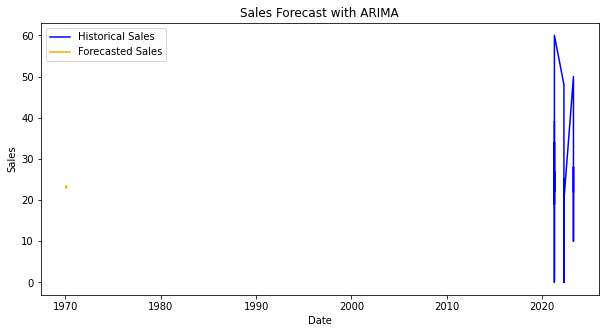

In [0]:
import mlflow
import mlflow.statsmodels
import matplotlib.pyplot as plt
with mlflow.start_run() as run:
    
    mlflow.log_param("ARIMA_order", (1, 1, 1))
    
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("SMAPE", smape)
    mlflow.log_metric("RMSE", rmse)
    
    mlflow.log_text(model_fit.summary().as_text(), "model_summary.txt")
    
    plt.figure(figsize=(10, 5))
    plt.plot(series, label='Historical Sales', color='blue')
    plt.plot(forecast.index, forecast, label='Forecasted Sales', color='orange')
    plt.title('Sales Forecast with ARIMA')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.savefig("arima_forecast_plot.png")
    
    mlflow.log_artifact("arima_forecast_plot.png")
    
    mlflow.statsmodels.log_model(model_fit, artifact_path="arima_model")

run_id = run.info.run_id
model_uri = f"runs:/{run_id}/arima_model"

loaded_model = mlflow.statsmodels.load_model(model_uri)

forecast_loaded = loaded_model.forecast(steps=12)

assert (forecast == forecast_loaded).all(), "Forecasts do not match!"